In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_iris

data = load_iris()
target = pd.DataFrame({'Label': data.target.tolist()}, index=range(len(data.target.tolist())))
target.replace({0: 'Iris-Setosa', 1: 'Iris-Versicolour', 2: 'Iris-Virginica'}, inplace=True)
features = pd.DataFrame({'sepal_length': data.data[:,0].tolist(), 'sepal_width': data.data[:,1].tolist(),
                         'petal_length': data.data[:,2].tolist(), 'petal_width': data.data[:,-1].tolist()}, index=range(len(data.data[:, 0].tolist())))

df = pd.concat([features, target], axis=1)

In [44]:
import os
ROOT = os.getcwd()
WORK_DIR = os.path.dirname(ROOT)

# ***EDA***

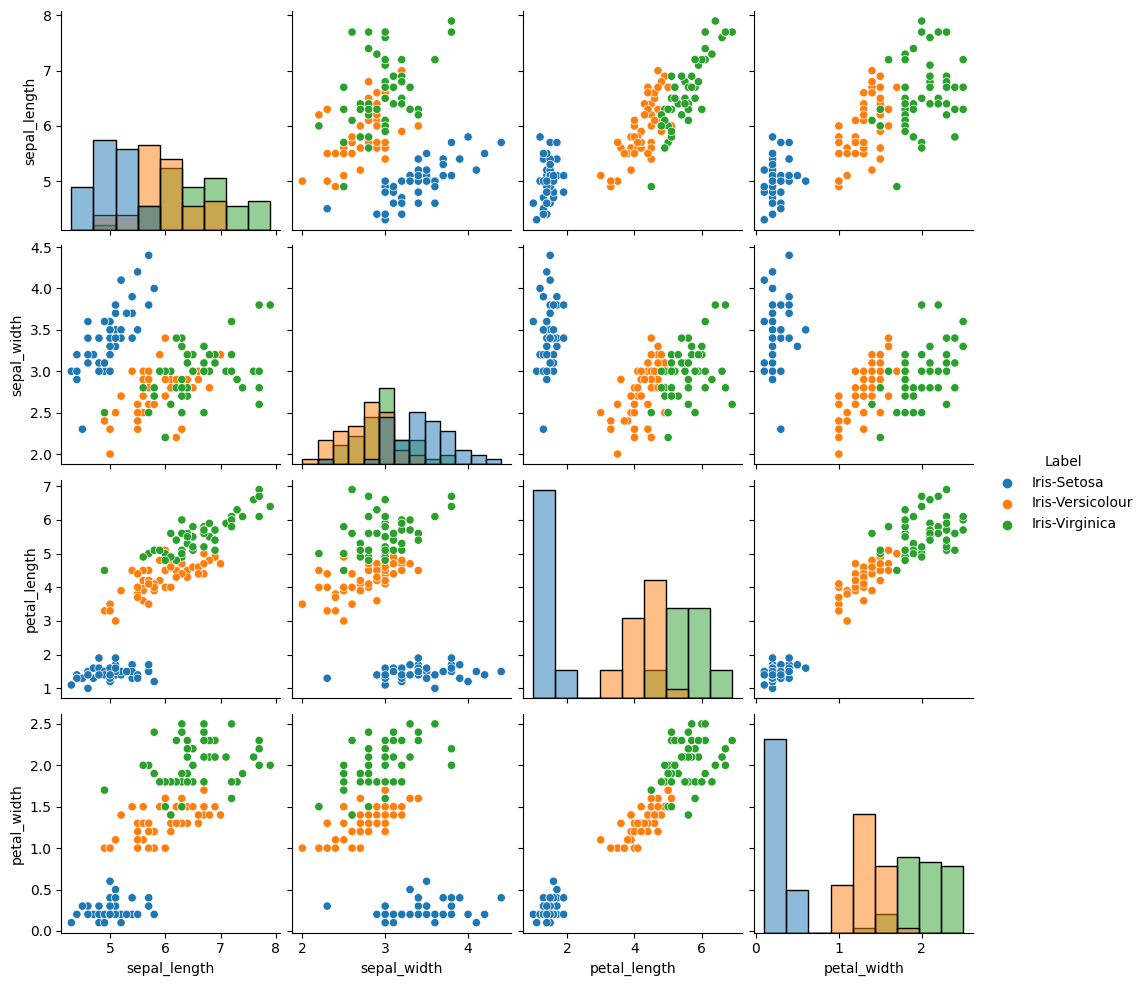

In [3]:
sns.pairplot(df, hue="Label", diag_kind="hist")

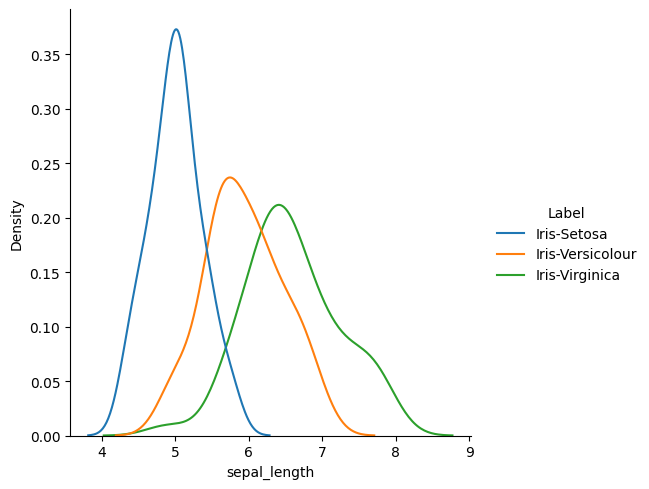

In [4]:
sns.displot(data=df, x="sepal_length", hue="Label", kind='kde')

<AxesSubplot: xlabel='sepal_length', ylabel='Label'>

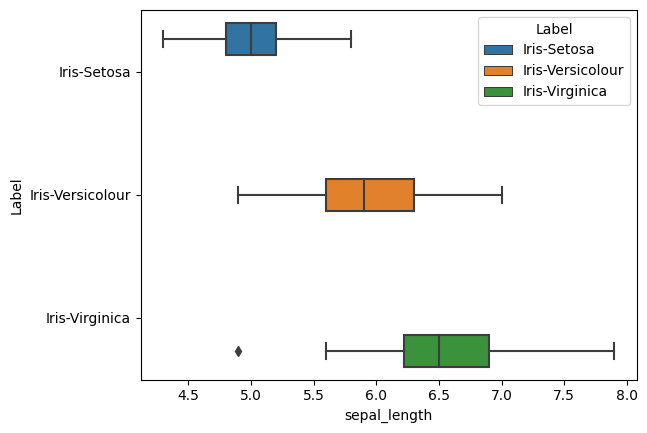

In [5]:
sns.boxplot(data=df, x="sepal_length", y="Label", hue='Label')

<AxesSubplot: xlabel='sepal_length', ylabel='Count'>

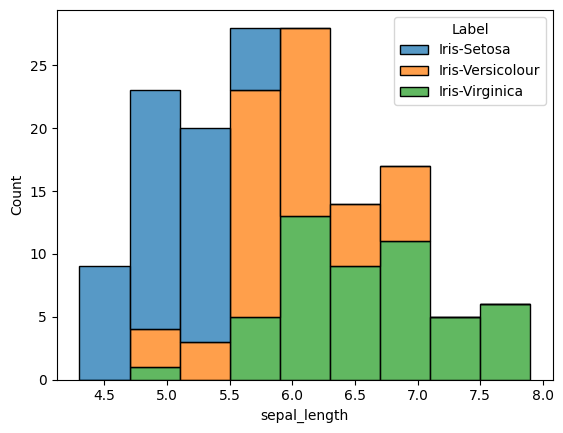

In [6]:
sns.histplot(data=df, x="sepal_length", hue="Label", multiple="stack")

# ***Modeling***

In [7]:
class Kmeans:
    
    def __init__(self, K, iters, is_plot=False) -> None:
        self.K = K
        self.iters = iters
        self.is_plot = is_plot
        # list of sample indices for each cluster
        self.clusters = [[] for _ in range(self.K)]

        # the centers (mean vector) for each cluster
        self.centroids = []

    def fit(self, X):
        pass
    
    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape
        
        # Initial centroids
        random_sample_idx = np.random.choice(self.n_samples, self.K, replace=True)
        self.centroids = [self.X[idx] for idx in random_sample_idx]
        
        for i in range(self.iters):
            
            # Seek clusters being the closest to centroids
            self.clusters = self.get_clusters(self.centroids)
            
            if self.is_plot:
                self.plot()
            
            # Update the new centroids
            old_centroids = self.centroids
            self.centroids = self.get_new_centroids(self.clusters)
            
            # Check if the clusters are converged
            if self.is_converged(old_centroids, self.centroids):
                break
                
            if self.is_plot:
               self.plot()
               
                
        return self.get_cluster_labels(self.clusters)
            
    def get_clusters(self, centroids):
        clusters = [[] for _ in range(self.K)]
        
        for idx, sample in enumerate(self.X):
            centroids_idx = self.closest_distance(sample, centroids)
            clusters[centroids_idx].append(idx)
        
        return clusters
    
    def get_new_centroids(self, clusters):
        centroids = np.zeros((self.K, self.n_features))
        
        for idx, cluster in enumerate(clusters):
            
            cluter_mean = np.mean(self.X[cluster], axis=0)
            centroids[idx] = cluter_mean

        return centroids    
    
    @staticmethod
    def euclidean_distance(sample, centroid):
        return np.sqrt(np.sum((sample - centroid) ** 2))
    
    def closest_distance(self, sample, centroids):
        distance = [self.euclidean_distance(sample, centroid) for centroid in centroids]
        closest_idx = np.argmin(distance)
        
        return closest_idx
    
    def get_cluster_labels(self, clusters):
        labels = np.empty(self.n_samples)
        
        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                labels[sample_idx] = cluster_idx
        
        return labels
    
    def is_converged(self, old_centroids, new_centroids):
        distances = [self.euclidean_distance(old_centroids[i], new_centroids[i]) for i in range(self.K)]
        
        return sum(distances) == 0
    
    def plot(self):
        fig, ax = plt.subplots(figsize=(12,8))
        
        for i, cluster in enumerate(self.clusters):
            point = self.X[i].T
            
            ax.scatter(*point)
        
        for point in self.centroids:
            ax.scatter(*point, marker='x', c='#1f77b4', linewidths=2)
        
        plt.show()
        

In [8]:
X = features.values

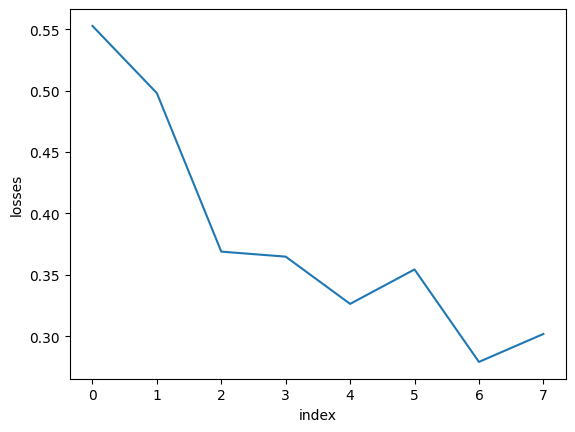

In [11]:
# Find best K for Kmean Clustering

losses = []
K = [i for i in range(3, 11)]
try:
    for k in K:
        kmeans = Kmeans(K=k, iters=100, is_plot=False)
        kmeans.fit(X)
        predict = kmeans.predict(X)
        loss = silhouette_score(X, predict)
        losses.append(loss)

    k_visualize = pd.DataFrame({'losses': losses}).reset_index()
    sns.lineplot(
        data=k_visualize,
        x="index", y="losses",
        markers=True, dashes=False
    )
except Exception as e:
    print(e)

In [22]:
final_K = losses.index(min(losses))
final_K

6

In [23]:
kmeans = Kmeans(K=3, iters=100, is_plot=False)
kmeans.fit(X)
predict = kmeans.predict(X)

In [24]:
features['predict'] = predict

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(features.iloc[:, :4])

PCA(n_components=3)

In [26]:
reduced_feature = pca.transform(features.iloc[:, :4])

In [27]:
visualize = pd.DataFrame(reduced_feature, columns=['1', '2', '3'])
visualize['predict'] = predict
visualize

,1,2,3,predict
0,-2.684126,0.319397,-0.027915,1.0
1,-2.714142,-0.177001,-0.210464,1.0
2,-2.888991,-0.144949,0.017900,1.0
3,-2.745343,-0.318299,0.031559,1.0
4,-2.728717,0.326755,0.090079,1.0
...,...,...,...,...
145,1.944110,0.187532,0.177825,0.0
146,1.527167,-0.375317,-0.121898,2.0
147,1.764346,0.078859,0.130482,0.0
148,1.900942,0.116628,0.723252,0.0


In [29]:
features

,sepal_length,sepal_width,petal_length,petal_width,predict
0,5.1,3.5,1.4,0.2,1.0
1,4.9,3.0,1.4,0.2,1.0
2,4.7,3.2,1.3,0.2,1.0
3,4.6,3.1,1.5,0.2,1.0
4,5.0,3.6,1.4,0.2,1.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,0.0
148,6.2,3.4,5.4,2.3,0.0


In [32]:
# import the libraries
import numpy as np
import pandas as pd 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py

# 3d scatterplot using plotly
Scene = dict(xaxis = dict(title  = 'Axis 1'),yaxis = dict(title  = 'Axis 2'),zaxis = dict(title  = 'Axis 3'))

# model.labels_ is nothing but the predicted clusters i.e y_clusters
x = visualize['1'].values
y = visualize['2'].values
z = visualize['3'].values

labels = visualize['predict'].values
trace = go.Scatter3d(x=x, y=x, z=x, mode='markers',marker=dict(color = labels, size= 10, line=dict(color= 'black',width = 10)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

In [18]:
silhouette_score(X, predict)

0.4777970036973851

In [50]:
from sklearn.cluster import KMeans

In [54]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
predict = kmeans.predict(X)

/Users/phamminhlong/miniconda3/envs/mlops/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/phamminhlong/miniconda3/envs/mlops/lib/python3.8/site-packages/threadpoolctl.py:1019: RuntimeWarning:

libc not found. The ctypes module in Python 3.8 is maybe too old for this OS.



In [55]:
predict

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0], dtype=int32)

In [56]:
silhouette_score(X, predict)

0.6354210747967928

# ***Apply for Image***

In [34]:
from skimage import io
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
from IPython.core.display import Image, display

/var/folders/l3/nmmhn_j97ssg8t3hcyzck85m0000gn/T/ipykernel_68342/2555458203.py:6: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



In [45]:
path_img = os.path.join(WORK_DIR, 'images/lena.jpg')

def read_image(path_img):
    display(Image(path_img, width=250, unconfined=True))
    img = io.imread(path_img)
    return img

def convert_image2D(img):
    data_img = (img / 255.0).reshape(-1,img.shape[-1]) # chuyển ma trận 128x128x3 về mảng 2 chiều 
    return data_img

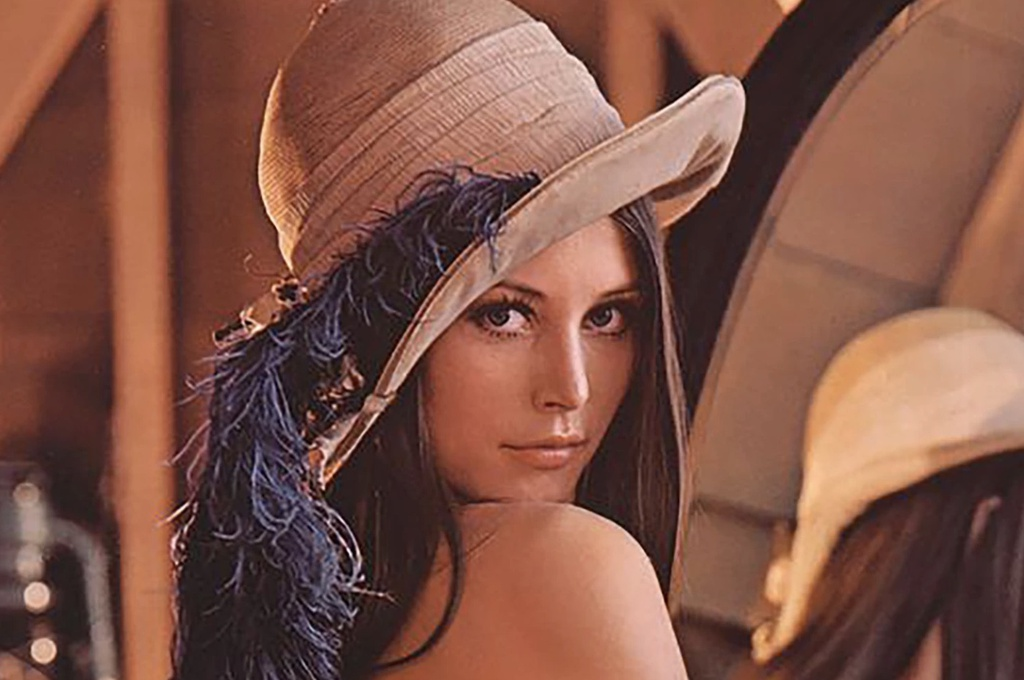

In [46]:
img = read_image(path_img)

reduced_img = convert_image2D(img)

In [51]:
X = reduced_img

In [52]:
kmeans = Kmeans(K=3, iters=100, is_plot=False)
kmeans.fit(X)
predict = kmeans.predict(X)

In [55]:
kmeans.centroids

array([[0.60482881, 0.37957042, 0.30120405],
       [0.28218788, 0.16834195, 0.15794889],
       [0.82004458, 0.63165332, 0.54153364]])

In [59]:

compressed_image = kmeans.centroids[predict.astype(int)].reshape(img.shape)
print(compressed_image)
image.imsave(os.path.join(WORK_DIR, 'images/compressed_lena.jpg'), compressed_image)


[[[0.60482881 0.37957042 0.30120405]
  [0.60482881 0.37957042 0.30120405]
  [0.60482881 0.37957042 0.30120405]
  ...
  [0.60482881 0.37957042 0.30120405]
  [0.60482881 0.37957042 0.30120405]
  [0.60482881 0.37957042 0.30120405]]

 [[0.60482881 0.37957042 0.30120405]
  [0.60482881 0.37957042 0.30120405]
  [0.60482881 0.37957042 0.30120405]
  ...
  [0.60482881 0.37957042 0.30120405]
  [0.60482881 0.37957042 0.30120405]
  [0.60482881 0.37957042 0.30120405]]

 [[0.60482881 0.37957042 0.30120405]
  [0.60482881 0.37957042 0.30120405]
  [0.60482881 0.37957042 0.30120405]
  ...
  [0.60482881 0.37957042 0.30120405]
  [0.60482881 0.37957042 0.30120405]
  [0.60482881 0.37957042 0.30120405]]

 ...

 [[0.60482881 0.37957042 0.30120405]
  [0.60482881 0.37957042 0.30120405]
  [0.60482881 0.37957042 0.30120405]
  ...
  [0.28218788 0.16834195 0.15794889]
  [0.28218788 0.16834195 0.15794889]
  [0.28218788 0.16834195 0.15794889]]

 [[0.60482881 0.37957042 0.30120405]
  [0.60482881 0.37957042 0.30120405]
